# It's a Start

### Imports

In [29]:
import simpy
import itertools
import numpy as np
import matplotlib.pyplot as plt

### Creative liberties

As we don't have all of the facts / estimates yet, I'll have to take... creative liberties.

I'll say that the café is open from 06:30 to 15:30, that the main rush hour is between 8 and 9, and that there's then another lesser rush during lunch (11:30 to 13:00).

So, essentially:

| Time | Customers per hour (arrival rate (lambda)) |
| ---- | ------------------------------------------ |
| 06:30 - 08:00 | 10 |
| 08:00 - 09:00 | 50 (rush) |
| 09:00 - 11:30 | 20 |
| 11:30 - 13:00 | 40 (lesser rush) |
| 13:00 - 15:30 | 15 |

... so this would be a "non-homogeneous" Poisson process, which SimPy DOES NOT have built in. So I'll be implementing it.

In [ ]:
rates = {
    90: 10/60,  # 06:30 - 08:00 --> 90 minutes. 
    150: 50/60, # 08:00 - 09:00 --> 90+60 = 150 minutes
    330: 20/60, # And so on.
    390: 40/60, 
    540: 15/60  # - 15:30, end of day.
}
closing_time = 540

# We'll want to not do things like this.

### Metrics that I'm going to keep track of: a checklist.

1) How long customers have to wait, from when they arrive at the café to when they pick up their order.
    - Would also be nice to see how long customers wait in each "act" (waiting to order + ordering, waiting for their order, picking up their order).  
2) How well all resources are utilized (employees in particular), how much idle time they have.

In [31]:
class Stats:
    def __init__(self):
        # CUSTOMER TIME-TRACKING
        self.register_queue_time = []           # Time each customer spent waiting to place their order.
        self.pickup_queue_time = []             # Time each custimer spent picking up their order.
        self.total_time_in_system = []          # Total time each customer spent from arrival time to pickup time.
        
        self.time_until_prep_begins = []        # The time from the customer places the order until a barista begins working on it.

        # OTHER CUSTOMER-RELATED MEASURES
        self.avg_length_register_queue = []     # This is a list because we might also want to graph this. Average length of queue per every hour, or something.
        self.avg_length_pickup_queue = []       # I don't think this has ever not been 0. I'm tracking it for the sake of consistency, though.
        self.avg_count_customers_waiting = []   # Could also be cool to graph.

        # TODO: RESOURCE UTILIZATION


### Time distributions defined

These are based on my whims only.

In [32]:
# Once again, we have yet to pin down the service time distribution,
# but to start implementing I'll just assume that it takes at least 5 seconds
# and that the mean is 45 seconds with a standard deviation of 10. Or something.
def order_time(rng):
    '''How long it takes a customer to order, in seconds.'''
    return max(5, rng.normal(45, 10)) 



# ... it's gotta take at least 5 seconds, that's if you're just taking out a croissant and putting it on a dish or something.
# I'll just take a wild guess of 3 minutes (180 seconds) as the mean and 20 seconds as the standard deviation.
# Also I added the time it takes to pay. 
def making_order_time(rng):
    '''How long it takes to get the order ready.
    TODO: We might want to change this process later, add coffe machines and such as resources, and so on.
    For now though, it's just a distribution like so.'''

    #       Time taken to order             Time taken to pay
    return (max(10, rng.normal(180, 20)) + max(3, rng.normal(7, 3)))



# It's gotta take at least a second.
# I'm just going to be optimistic and guess that the mean is 5 seconds, and the std is 1.
def pickup_time(rng):
    '''How long it takes the customer to pick up the order.'''
    return max(1, rng.normal(5, 1))

### IDEAS FOR WHAT ELSE TO USE:
- For arrivals:
    - Exponential with a variable that doesn't change throughout the run (take out the rates I hard-coded)
- Customer making order:
    - Gamma:
        shortest time:  10 sek
        longest time:   2 min
        mid:            45 sek
- Barista preparing order
    - Triangular: 
        shortest time: 15 sek
        longest time:  10 min
        mid (top of triangle): 3 min
        - Also, distributions for particular tools:
            - Coffee machine:   Uniform     1 til 3 mín
            - Oven:             Uniform     1 til 5 mín
- Fetching order
    - TODO: TAKING THIS OUT

### Meatier functions

In [33]:

def customer(env, stats_keeper, ID, register, barista, pickup, rng):
    '''Customer's "lifecycle".
    They arrive, wait in line, order + pay, wait for their order, and then pick up their order.
    
    Params:
        - env:          simpy.Environment.
        - ID:           int, customer's ID.
        - register:     int, ID of the register they queue at.
        - rng:          RNG.

    Returns:
        - everlasting happiness

    '''

    arrival = env.now
    print(f'{ID} arrives at {arrival:.2f}')

    # TODO: I could refactor these "acts" into different function. For readibility. 

    # # # # # # # # # # # # # # 
    #   ACT I: The Register   #
    # # # # # # # # # # # # # # 
    with (register.request() as req):
        yield req # Waiting in line.

        start_ordering = env.now

        print(f"{ID} begins ordering at {start_ordering:.2f}")

        # We wait while the customer places their order.
        ordering = order_time(rng)
        yield env.timeout(ordering)

        stop_ordering = env.now
        print(f"{ID} finishes ordering at {stop_ordering:.2f}")

    # # # # # # # # # # # # # # 
    #   ACT II: The Waiting   #
    # # # # # # # # # # # # # # 
    with (barista.request() as req):
        yield req

        prep_time = making_order_time(rng)
        prep_begin = env.now
        print(f"{ID}'s order preperation begins at {prep_begin:.2f}")

        yield env.timeout(prep_time)
        time_ready = env.now
        print(f"{ID}'s is ready for pickup at {time_ready:.2f}")


    # # # # # # # # # # # # # # 
    #   ACT III: The Pickup   #
    # # # # # # # # # # # # # #
    with pickup.request() as req:
        yield req

        start_pickup = env.now
        print(f"{ID} goes to pick up their order at {start_pickup:.2f}")

        pickupp_time = pickup_time(rng)
        yield env.timeout(pickupp_time)

        end_time = env.now
        print(f"{ID} leaves at {end_time:.2f}")

    # # # # # # # # # # # # # # #
    #   ALSO: Gathering Stats   #
    # # # # # # # # # # # # # # #

    time_in_register_queue = (start_ordering - arrival)
    time_in_pickup_queue = (time_ready - start_pickup)
    total_time = end_time - arrival
    stats_keeper.register_queue_time.append(time_in_register_queue)  # TODO: Do we maybe want :.2f?
    stats_keeper.pickup_queue_time.append(time_in_pickup_queue)
    stats_keeper.total_time_in_system.append(total_time)

    time_from_order_to_prep_start = time_ready - prep_begin
    stats_keeper.time_until_prep_begins.append(time_from_order_to_prep_start)


In [34]:

def arrivals_generator(env, stats_keeper, register, barista, pickup, rates, closing_time, seed=None):
    '''
    Generates customer arrival times using a
        PIECEWISE-CONSTANT NON-HOMOGENEOUS POISSON PROCESS.

    Params:
        - env:      simpy.Environment.
        - rates:    a dictionary, the keys being time passed (breakpoints) in minutes 
                    and the values being arrival rates.
        - seed:     int, seed for RNG.

    Returns:
        - Arrivals. Floats.
    '''

    rng = np.random.default_rng(seed)
    breakpoints = sorted(rates.keys())

    def get_rate(time):
        '''Returns arrival rate for current time, however we defined it.'''
        for point in breakpoints:
            if (time < point):
                return rates[point]
        return rates[breakpoints[-1]] # If past all, just use the last one.


    customer_ID = 0
    inter_arrival = 0
    while True:

        if ((env.now + inter_arrival) >= closing_time):
            print(f"\nCLOSING SHOP. \nNo more arrivals after closing at {closing_time:.2f}.\n")
            return

        rate = get_rate(env.now)                    # Rate at this time.

        inter_arrival = rng.exponential(1 / rate)   # Inter arrival from exponential dist.
        yield env.timeout(inter_arrival)            # Waiting until the next arrival.

        env.process(customer(
            env, 
            stats_keeper,
            customer_ID, 
            register, 
            barista,
            pickup,
            rng
        ))
        customer_ID += 1

I should probably add a short description above each function. Readibility reasons.

In [ ]:
def simulate(num_registers, num_baristas, num_pickups, rates, closing_time, ttl):
    '''
    Simulates the process with the specified:
        - num_registers:    int, number of registers / staff at registers.
        - num_baristas:     int, number of baristas (those preparing orders).
        - num_pickups:      int, number of places where drinks can be picked up.
        - rates:            dict, the customers-per-hour rate for each period of time.
        - closing_time:     int, this is when new customers should stop coming in. This is just when we stop taking orders.
        - ttl:              number, "time-to-live", how long the simulation will be allowed to run (in case there are some customers still awaiting their orders).

    Returns:
        - statistics:       Stats class object. Just stats for this particular run.
    '''
    
    env = simpy.Environment()
    statistics = Stats()

    register = simpy.Resource(env, capacity=num_registers)      # Note: SimPy resources are FIFO by default.
    barista = simpy.Resource(env, capacity=num_baristas)        # We have [CAPACITY] amount of baristas, each can focus on one order at a time.
    pickup = simpy.Resource(env, capacity=num_pickups)          # One can pick up their order at a time.

    env.process(arrivals_generator(
        env=env, 
        stats_keeper=statistics,
        register=register, 
        barista=barista,
        pickup=pickup,
        rates=rates, 
        closing_time=closing_time,
        seed=360
    ))
    env.run(until=ttl)  # TODO: NOTE: way beyond closing time. I just wanted to see how much would be done in this time. People stop coming in after closing.

    return statistics


In [36]:
def print_stats(statistics):
    print("Total times in register queue:\n", statistics.register_queue_time)
    print("Time from when the order is placed until a barista begins working on it:\n", statistics.time_until_prep_begins)
    print("Total times in pickup queue:\n", statistics.pickup_queue_time)
    print("Total times in system:\n", statistics.total_time_in_system)
    # We'll want to add more.

In [37]:
def plot_stats(statistics):
    plt.plot(statistics.total_time_in_system)
    plt.ylabel('Waiting time for customers 0 to i')
    plt.show()
    
    plt.plot(statistics.register_queue_time)
    plt.ylabel('Waiting time in register queue for customers 0 to i')
    plt.show()
    
    plt.plot(statistics.pickup_queue_time)
    plt.ylabel('Waiting time in pickup queue for customers 0 to i')
    plt.show()
    
    plt.plot(statistics.time_until_prep_begins)
    plt.ylabel('Waiting time until barista begins working on order for customers 0 to i')
    plt.show()

## Default run, default values

We start out with:
| Number | Resource | Explanation |
| ------ | -------- | ----------- |
| 1 | Register | Order-takers |
| 2 | Barista | Order-preparers |
| 1 | Pickup station | Where customers pick up their orders |

* We'll want to define more, obviously.

In [38]:
default = simulate(1, 2, 1, rates, closing_time, 1000)

0 arrives at 2.90
0 begins ordering at 2.90
1 arrives at 10.67
2 arrives at 16.23
3 arrives at 18.49
4 arrives at 20.84
5 arrives at 21.08
6 arrives at 37.41
7 arrives at 42.86
0 finishes ordering at 44.67
0's order preperation begins at 44.67
1 begins ordering at 44.67
8 arrives at 53.96
9 arrives at 72.50
10 arrives at 74.31
11 arrives at 74.54
12 arrives at 81.09
13 arrives at 87.46
1 finishes ordering at 88.27
1's order preperation begins at 88.27
2 begins ordering at 88.27
14 arrives at 95.65
15 arrives at 97.07
16 arrives at 102.29
17 arrives at 102.41
18 arrives at 103.23
19 arrives at 104.46
20 arrives at 104.89
21 arrives at 105.02
22 arrives at 109.22
23 arrives at 109.58
2 finishes ordering at 110.40
3 begins ordering at 110.40
24 arrives at 111.45
25 arrives at 111.96
26 arrives at 112.90
27 arrives at 114.43
28 arrives at 115.23
29 arrives at 116.16
30 arrives at 116.43
31 arrives at 117.04
32 arrives at 118.26
33 arrives at 120.78
34 arrives at 121.84
35 arrives at 122.12

#### Stats Display

Total times in register queue:
 [0.0, 33.99450481726547, 72.04571357193163, 91.90815775522, 137.06695156302592, 164.01066137648004, 169.17265729264338, 205.31899761978113, 239.26819283668635]
Time from when the order is placed until a barista begins working on it:
 [175.46491668519067, 193.38719491751027, 187.87699054472859, 202.0904407133081, 203.03489162049766, 191.59910556751078, 172.7962548920077, 190.58679088333793, 168.1939674133473]
Total times in pickup queue:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Total times in system:
 [220.17948490611238, 274.3107123527191, 397.22174450414354, 471.1209332537287, 594.9341759800101, 659.9788091186014, 752.6203913618342, 826.4007094354606, 903.0399598933511]


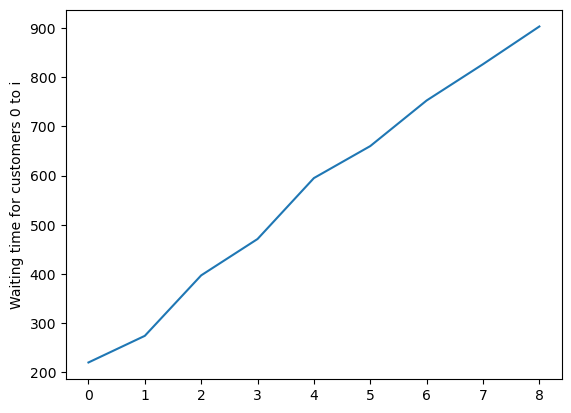

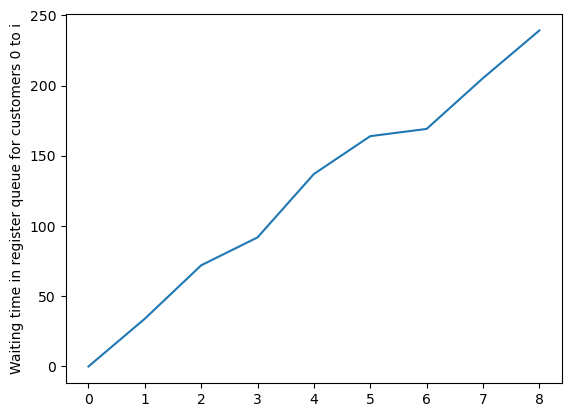

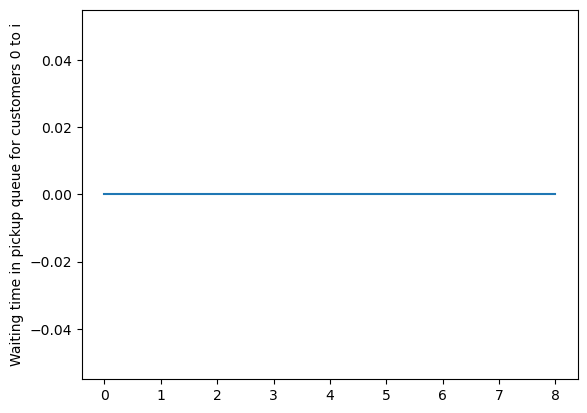

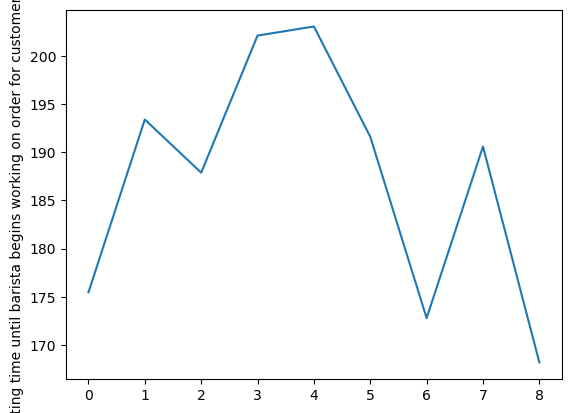

In [39]:
print_stats(default)
plot_stats(default)

*Insert thoughtful discussion of results.

# Experiment #1: Add one more register.

In [ ]:
exp_1 = simulate(2, 2, 1, rates, closing_time, 1000)

0 arrives at 2.90
0 begins ordering at 2.90
1 arrives at 10.67
1 begins ordering at 10.67
2 arrives at 16.23
3 arrives at 18.57
4 arrives at 18.82
5 arrives at 35.14
6 arrives at 40.59
1 finishes ordering at 43.70
1's order preperation begins at 43.70
2 begins ordering at 43.70
0 finishes ordering at 44.67
0's order preperation begins at 44.67
3 begins ordering at 44.67
7 arrives at 51.69
8 arrives at 58.24
9 arrives at 64.61
10 arrives at 72.80
11 arrives at 78.93
12 arrives at 86.06
2 finishes ordering at 87.31
4 begins ordering at 87.31
3 finishes ordering at 103.43
5 begins ordering at 103.43
13 arrives at 112.12
14 arrives at 113.35
15 arrives at 113.78
16 arrives at 113.91
17 arrives at 118.11
18 arrives at 118.47
19 arrives at 120.34
20 arrives at 123.99
21 arrives at 124.50
4 finishes ordering at 124.90
6 begins ordering at 124.90
22 arrives at 125.44
23 arrives at 126.24
24 arrives at 127.17
25 arrives at 127.44
26 arrives at 128.05
27 arrives at 129.27
28 arrives at 131.79
29

#### Stats display

Total times in register queue:
 [0.0, 0.0, 26.096834146621084, 27.47833701886035, 68.49175077248353, 68.29254197501439, 84.30236464959538, 82.80657183910422, 108.57147011137968, 121.20171195619996]
Time from when the order is placed until a barista begins working on it:
 [162.89767525535083, 175.46491668519067, 146.3358529389066, 183.08721644421178, 218.0039553484276, 196.70946258234721, 172.7962548920077, 202.28519732905204, 156.75959674444562, 183.84368980764498]
Total times in pickup queue:
 [0.0, 0.0, 0.0, 0.0, 0.0, -0.8756322551387257, 0.0, 0.0, 0.0, 0.0]
Total times in system:
 [209.3268021353789, 214.05141331663626, 352.5369095593246, 380.6809834179878, 569.4225396112168, 558.3123798497514, 721.3149835988472, 743.7558736028618, 859.5477856165863, 906.9777911394546]


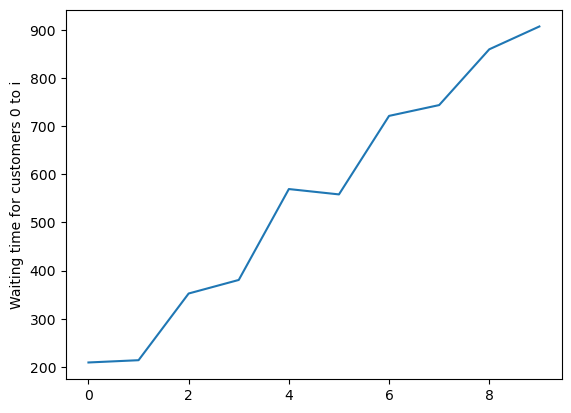

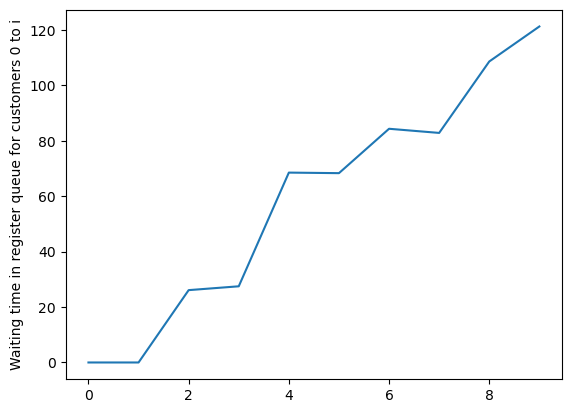

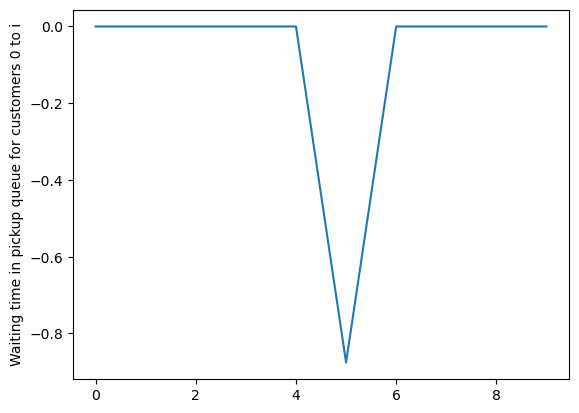

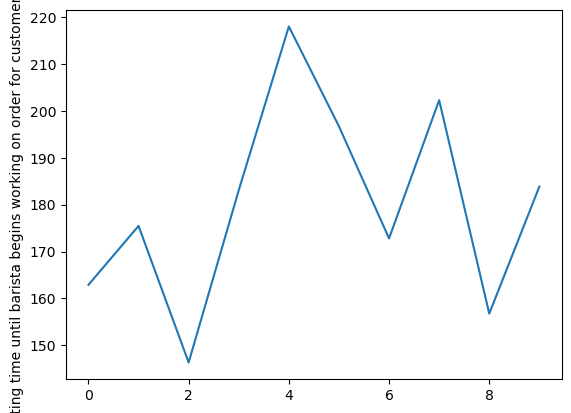

In [ ]:
print_stats(exp_1)
plot_stats(exp_1)

... well something went wrong here. A negative number of waiting? How?
Adding a register also doesn't really seem to be making things significantly better.

# Experiment #2: Impossible numbers.

In [ ]:
exp_2 = simulate(100, 100, 100, rates, closing_time, 1000)

0 arrives at 2.90
0 begins ordering at 2.90
1 arrives at 10.67
1 begins ordering at 10.67
2 arrives at 16.23
2 begins ordering at 16.23
3 arrives at 18.57
3 begins ordering at 18.57
4 arrives at 34.90
4 begins ordering at 34.90
1 finishes ordering at 43.70
1's order preperation begins at 43.70
0 finishes ordering at 44.67
0's order preperation begins at 44.67
5 arrives at 45.99
5 begins ordering at 45.99
6 arrives at 46.22
6 begins ordering at 46.22
7 arrives at 52.59
7 begins ordering at 52.59
8 arrives at 58.72
8 begins ordering at 58.72
2 finishes ordering at 61.92
2's order preperation begins at 61.92
3 finishes ordering at 62.48
3's order preperation begins at 62.48
9 arrives at 64.16
9 begins ordering at 64.16
10 arrives at 66.31
10 begins ordering at 66.31
4 finishes ordering at 72.51
4's order preperation begins at 72.51
7 finishes ordering at 77.30
7's order preperation begins at 77.30
5 finishes ordering at 80.29
5's order preperation begins at 80.29
6 finishes ordering at 81

Total times in register queue:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

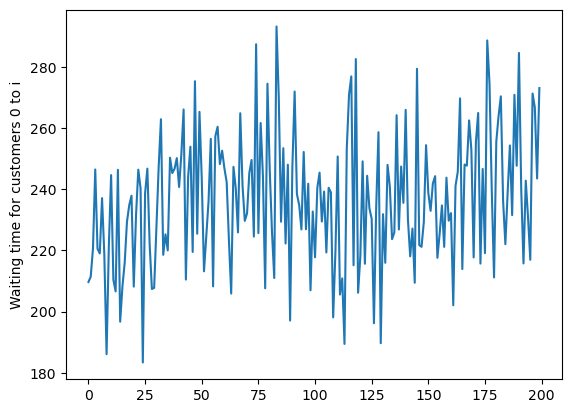

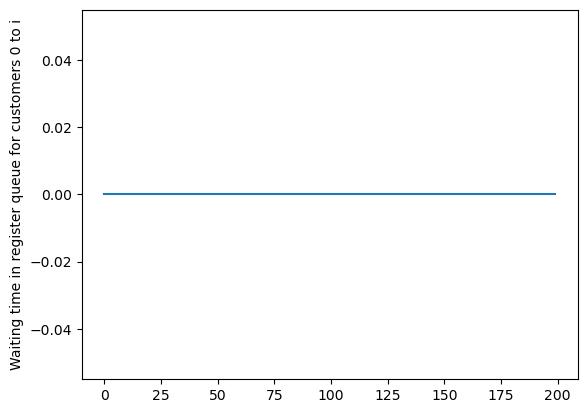

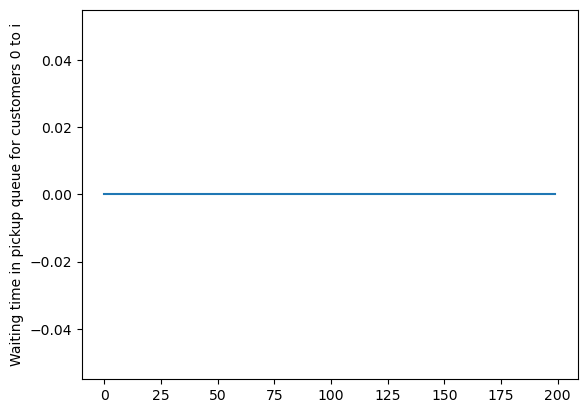

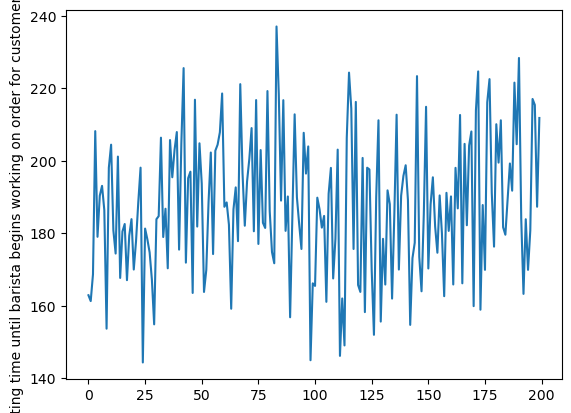

In [ ]:
print_stats(exp_2)
plot_stats(exp_2)

I'll analyze this when I'm less eepy.

# TODOS:

- Fix whatever bug made the waiting time a negative number.
- Put in more realistic distributions.
- Eventually add more resources, like coffee machines and whatnot.
    - Make coffee machines and such able to break down.
- Implement employee schedules.
    - Remember that each employee should be on either barista duty or register duty for their entire shift.
    - Also make the schedule a variable that we can play around with.
- Maybe set up an 'Experiment' class object, such that we can define a set of experiments and easily loop through them. I think that could be a good idea.